In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
import os
import sys
import ipywidgets as widgets

cuda_input = widgets.BoundedIntText(
    value=0,
    min=0,
    max=1,
    step=1,
    description='GPU to use:',
)
button = widgets.Button(
    description='Set',
    icon='check'
)

def set_gpu_to_use(btn=None):
    os.environ['CUDA_VISIBLE_DEVICES'] = str(cuda_input.value)
    
display(cuda_input)
set_gpu_to_use()
button.on_click(set_gpu_to_use)
display(button)

BoundedIntText(value=0, description='GPU to use:', max=1)

Button(description='Set', icon='check', style=ButtonStyle())

In [2]:
from torch import functional as F
from torch import nn
from torchvision import datasets, transforms, models
import torch

from tqdm import notebook as tqdm
from torch.utils.tensorboard import SummaryWriter

In [14]:
from smoothing import AverageCounter, MovingAverageCounter, NoAugmenter

In [4]:
def train(loader, model, criterion, optimizer, writer, epoch, augmenter, device=torch.device('cpu')):
    assert model.training
    loss_cnt = MovingAverageCounter(5)
    iteration = (epoch - 1) * len(loader.dataset)

    for X, y in tqdm.tqdm(loader):
        input = X.to(device)
        target = y.to(device).to(torch.float32)
        X_aug, y_aug = augmenter.augment_tensors(input, target, model)
        y_pred = model(X_aug)
        loss = criterion(y_pred, y_aug)
        loss_cnt.add(loss.item())
        iteration += len(y)
        writer.add_scalar('Loss/train', loss_cnt.get_average(), iteration)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

In [5]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(device))
else:
    device = torch.device('cpu')

NVIDIA Tesla K80


In [6]:
img_mean = [0.5063, 0.4258, 0.3832]
img_std = [0.2660, 0.2452, 0.2414]
celeba_transforms = [
    transforms.r
    transforms.ToTensor(),
#    transforms.Normalize(img_mean, img_std),  # kinda painful to do that with adversarial attacks
]
celeba_transform = transforms.Compose(celeba_transforms)

celeba_transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
] + celeba_transforms)

In [7]:
celeba_train_dataset = datasets.CelebA('dsets/', split='train', target_type='attr',
                                      download=False, transform=celeba_transform_train)

In [8]:
celeba_test_dataset = datasets.CelebA('dsets/', split='valid', target_type='attr',
                                      download=False, transform=celeba_transform)

In [9]:
class CelebaModel(nn.Module):
    def __init__(self):
        super(CelebaModel, self).__init__()
        self.resnet50 = models.resnet50(pretrained=True)
        self.resnet50.fc = nn.Linear(2048, 40)

    def forward(self, x):
        return self.resnet50(x)
    
class CelebaModel18(nn.Module):
    def __init__(self):
        super(CelebaModel18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=True)
        self.resnet18.fc = nn.Linear(512, 40)

    def forward(self, x):
        return self.resnet18(x)

In [10]:
batch_size=128

In [19]:
train_loader = torch.utils.data.DataLoader(celeba_train_dataset, batch_size)
test_loader = torch.utils.data.DataLoader(celeba_test_dataset, batch_size)

In [24]:
criterion = nn.BCEWithLogitsLoss()
model = CelebaModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
augmenter = NoAugmenter()

In [25]:
writer = SummaryWriter(log_dir='runs/celeba-uncert')

In [26]:
def uncertified_validate(loader, model, criterion, writer, epoch, device):
    assert model.training
    try:
        model.eval()
        loss_cnt = AverageCounter()
        accuracy_cnt = AverageCounter()
        with torch.no_grad():
            for X, y in tqdm.tqdm(loader):
                y_pred = model(X.to(device))
                y = y.to(device)
                accuracy_cnt.add(torch.mean(((y_pred > 0) == y).to(torch.float)).item())
                loss = criterion(y_pred, y.to(y_pred.dtype))
                loss_cnt.add(loss.item())
            writer.add_scalar('Loss/val', loss_cnt.get_average(), epoch)
            writer.add_scalar('Accuracy/val', accuracy_cnt.get_average(), epoch)
    finally:
        model.train()

In [ ]:
epoch = 10
while epoch <= 20:
    print(f'Epoch {epoch}')
    model.train()
    train(train_loader, model, criterion, optimizer, writer, epoch, augmenter, device)
    torch.save(model, f'celeba-uncert{epoch:02d}.pth')
    uncertified_validate(test_loader, model, criterion, writer, epoch, device)
    epoch += 1

Epoch 10


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 11


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 12


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 17


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 18


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/311 [00:00<?, ?it/s]

Epoch 19


  0%|          | 0/2544 [00:00<?, ?it/s]

In [35]:
uncertified_validate(test_loader, model, criterion, writer, epoch, device)

  0%|          | 0/311 [00:00<?, ?it/s]

In [32]:
assert model.training
try:
    model.eval()
    loss_cnt = AverageCounter()
    accuracy_cnt = AverageCounter()
    with torch.no_grad():
        for X, y in tqdm.tqdm(test_loader):
            y_pred = model(X.to(device))
            y = y.to(device)
            accuracy_cnt.add(torch.mean(((y_pred > 0) == y).to(torch.float)).item())
            loss = criterion(y_pred, y.to(y_pred.dtype))
            loss_cnt.add(loss.item())
        print('Loss/val', loss_cnt.get_average(), epoch)
        print('Accuracy/val', accuracy_cnt.get_average(), epoch)
finally:
    model.train()

  0%|          | 0/311 [00:00<?, ?it/s]

Loss/val 0.20287118967131404 9
Accuracy/val 0.9130268468734153 9


In [33]:
writer.flush()

In [21]:
torch.save(res_50, 'adv-big-res01.pth')

In [33]:
res_10_old = res_10

In [34]:
res_10 = calculate_radii(celeba_test_dataset, range(25), torch.load('celeba10.pth').to(device), 10**2, 10**4, 1e-3, 1., device=device, batch_size=batch_size)

  0%|          | 0/25 [00:00<?, ?it/s]

In [36]:
torch.save(res_10, 'eval10.pth')

In [28]:
def get_certified_accuracies(d):
    from smoothing import certified_accuracy
    radii = np.linspace(0, d['r'].view(-1).max())
    res = np.zeros_like(radii)
    for i, r in enumerate(radii):
        res[i] = certified_accuracy(d['y_pred'].view(-1), d['r'].view(-1), d['y'].view(-1), r)
    return radii, res

In [29]:
def pl(ax, d, **kwargs):
    radii, res = get_certified_accuracies(d)
    ax.plot(radii, res, **kwargs)

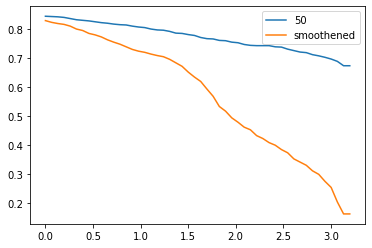

In [35]:
fig, ax = plt.subplots()
pl(ax, torch.load('adv-big-res01.pth'), label='50')
pl(ax, res_10, label='smoothened')

ax.legend()

In [44]:
(res_50['y_pred'] == res_50['y']).view(-1).to(torch.float).mean()

tensor(0.8430)

In [35]:
d = torch.load('eval10.pth')

In [36]:
radii_old = np.linspace(0, d['r'].view(-1).max())
res_old = np.zeros_like(radii_old)
for i, r in enumerate(radii_old):
    res_old[i] += certified_accuracy(d['y_pred'].view(-1), d['r'].view(-1), d['y'].view(-1), r)

In [37]:
from statsmodels.stats.proportion import proportion_confint

In [42]:
N = 10**6
est_lo, est_hi = proportion_confint(N, N, 2e-3, method='beta')

In [43]:
from scipy.stats import norm, binom_test

In [44]:
norm.ppf(est_lo)

4.346773698699431